In [87]:
import cv2
import os
import pandas as pd
import numpy as np
import keras, tensorflow as tf
import matplotlib.pyplot as plt
import shutil

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LSTM
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split


In [188]:
def extract(img, smaller):
        
    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    if(smaller):
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

        # Applying dilation on the threshold image
        dilation = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, rect_kernel, iterations = 1)
        # dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    else:
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

        # Applying dilation on the threshold image
        dilation = cv2.dilate(thresh1, rect_kernel, iterations = 2)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                    cv2.CHAIN_APPROX_NONE)

    return contours

In [192]:
def boundingbox(img_path, model):
    img = cv2.imread(img_path)
    contours = extract(img, False)

    sum = 0
    y_pred = []
    boxes = []
    im = img.copy()
    crops = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (255, 0, 0), 2)
            
        # Cropping the text block
        cropped = img[y:y + h, x:x + w]

        # extract each alphabet from each block
        contours2 = extract(cropped, True)
        
        for i in contours2:
            # count alphabets 
            sum += 1

            x2, y2, w2, h2 = cv2.boundingRect(i)
            
            cropped2 = img[y+y2: y+y2+h2, x+x2: x+x2+w2]
            
            # center_x = (x + x2 + w2 / 2) / img.shape[1]
            # center_y = (y + y2 + h2 / 2) / img.shape[0]
            # normalized_width = w2 / img.shape[1]
            # normalized_height = h2 / img.shape[0]

            # # Append the YOLO format coordinates to the boxes list
            # boxes.append([center_x, center_y, normalized_width, normalized_height])


            boxes.append([x+x2, y+y2, x+x2 + w2, y+y2 + h2]) 

            cropped2 = cv2.resize(cropped2, (64,64))
            
            crops.append(cropped2)

            cropped2 = cropped2.reshape((1, 64, 64, 3))

            y_pred.append(model.predict(cropped2))

    
    order = np.argsort([x[0] for x in boxes])
    boxes = [boxes[x] for x in order]
    crops = [crops[x] for x in order]
    y_pred = [y_pred[x] for x in order]
    
    y_pred = np.array(y_pred)
    # return sum, boxes, im, crops
    return sum, y_pred, boxes, im, crops


In [179]:
# each classes(62 classes) has 55 images 
model_training_csv = os.path.join(os.getcwd(), 'alphabets/english.csv')
model_image_training = os.path.join(os.getcwd(), 'alphabets')

# make dataframe for training model 
model_training_df = pd.read_csv(model_training_csv)
# add columns of image
model_training_df['img'] = ''
# get image for each image name
for i in range(len(model_training_df)):
    img_path = os.path.join(model_image_training, model_training_df.at[i, 'image'])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))

    model_training_df.at[i, 'img'] = img
# get all class names
class_names = model_training_df.label.unique()

# Convert each column to NumPy arrays
labels = model_training_df['label'].to_numpy()
images = np.array(model_training_df['img'].tolist())
image_names = model_training_df['image'].to_numpy()
new_image_names = np.array([(item.split('/')[1]).split('.')[0] for item in model_training_df['image']])

# split each class equaly
x_train, y_train, x_test, y_test = [], [], [], []
temp = []
for name in class_names:
    split = model_training_df[model_training_df.label == name]
    X = split['img']
    Y = split['label']
    Y = [np.where(class_names == label)[0] for label in Y]

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.8)

    x_train.extend(X_train)
    y_train.extend(Y_train)
    x_test.extend(X_test)
    y_test.extend(Y_test)


# shuffle order of train and test data
temp_x_train, temp_y_train, temp_x_test, temp_y_test = [], [], [], []

train_rand_order = np.arange(len(x_train))
test_rand_order = np.arange(len(x_test))
np.random.shuffle(train_rand_order)
np.random.shuffle(test_rand_order)
for i in train_rand_order:
    temp_x_train.append(x_train[i])
    temp_y_train.append(y_train[i])

for j in test_rand_order:
    temp_x_test.append(x_test[j])
    temp_y_test.append(y_test[j])    

x_train = np.array(temp_x_train, dtype=np.float32)
x_test = np.array(temp_x_test, dtype=np.float32)
y_train = np.array(temp_y_train)
y_test = np.array(temp_y_test)


# one-hot-encoded the label
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [180]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.2, 0.2],
    rotation_range=0.3,
)

datagen.fit(x_train)


In [236]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout

model.add(Dense(62, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_129 (Conv2D)         (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_130 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_131 (Conv2D)         (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 8, 8, 256)       

In [237]:
batch_size = 32

# initiate RMSprop optimizer
# Using M1 mac
# opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0005)
opt = keras.optimizers.legacy.Adam(learning_rate=0.0005)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

# history_1 = model.fit(x_train, y_train,
#                         batch_size=batch_size,
#                         epochs=10,
#                         validation_data=(x_test, y_test),
#                         shuffle=True)
history_1 = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        shuffle=True)


Epoch 1/100
85/85 [==============================] - 20s 234ms/step - loss: 6.8320 - accuracy: 0.0159 - val_loss: 4.1272 - val_accuracy: 0.0147
Epoch 2/100
85/85 [==============================] - 22s 252ms/step - loss: 4.1283 - accuracy: 0.0171 - val_loss: 4.1272 - val_accuracy: 0.0191
Epoch 3/100
85/85 [==============================] - 22s 258ms/step - loss: 4.1063 - accuracy: 0.0200 - val_loss: 4.1272 - val_accuracy: 0.0176
Epoch 4/100
85/85 [==============================] - 24s 279ms/step - loss: 4.0541 - accuracy: 0.0256 - val_loss: 4.1342 - val_accuracy: 0.0132
Epoch 5/100
85/85 [==============================] - 24s 277ms/step - loss: 4.0109 - accuracy: 0.0274 - val_loss: 4.1365 - val_accuracy: 0.0161
Epoch 6/100
85/85 [==============================] - 25s 296ms/step - loss: 3.9662 - accuracy: 0.0412 - val_loss: 4.1496 - val_accuracy: 0.0117
Epoch 7/100
85/85 [==============================] - 24s 288ms/step - loss: 3.8876 - accuracy: 0.0549 - val_loss: 4.1851 - val_accuracy:

In [80]:
train_img_path = os.path.join(os.getcwd(), "archive/train_v2/train")
test_img_path = os.path.join(os.getcwd(), "archive/test_v2/test")

train_csv_path = os.path.join(os.getcwd(), "archive/written_name_train_v2.csv")
test_csv_path = os.path.join(os.getcwd(), "archive/written_name_test_v2.csv")



df = pd.read_csv(train_csv_path)
cnt = 0
im = 0
boxes = []

# for i in range (df.shape[0]):
for i in range (100):
    # print(df['FILENAME'][i])
    img_name = os.path.join(train_img_path, df['FILENAME'][i])
    num_of_char, boxes, img, crop = boundingbox(img_name, model)
    # num_of_char, y_pred, boxes, img, crop = boundingbox(img_name, model)
    
    if num_of_char == len(str(df['IDENTITY'][i])):
        cnt += 1
        fileName = df['FILENAME'][i]
        shutil.copy(os.path.join(source_folder_images, fileName), os.path.join(destination_folder_images, fileName))

        label = ''
        for j in range(len(df['IDENTITY'][i])):
            label += df['IDENTITY'][i][j] + ' '
            temp = ' '.join(map(str, boxes[j]))
            label += temp
            label += '\n'
         

        fileName = fileName.split('.')
        new_filename = f"{fileName[0]}.txt"
        label_path = os.path.join(destination_folder_labels, new_filename)

        with open(label_path, "w") as label_file:
            label_file.write(label)

print(cnt)

12


In [186]:
word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)
print(boxes)

37eD4eT4svYspeMe688Tnen8TY
[[0.43083333333333335, 0.6055555555555555, 0.3466666666666667, 0.6044444444444445]]


In [232]:
ans = 'StandardRNNshavepoormemory'
num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), "com_text3.png"), model)
print(num_of_char)
word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)


1/1 [==============================] - 0s 14ms/step
26
sTcDSSFSRNY55cMcB88TmSm8TY


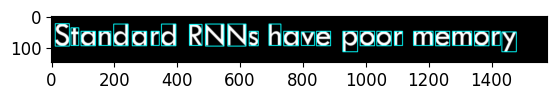

In [219]:
# save resulting image
for x1, y1, x2, y2 in boxes:
    rect = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(cv2.bitwise_not(img))
# plt.imshow(crop[1])

In [234]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 4.805404, Accuracy: 0.035924
 Test Loss: 4.826253, Accuracy: 0.054252

[[0 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 0 0 ... 3 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


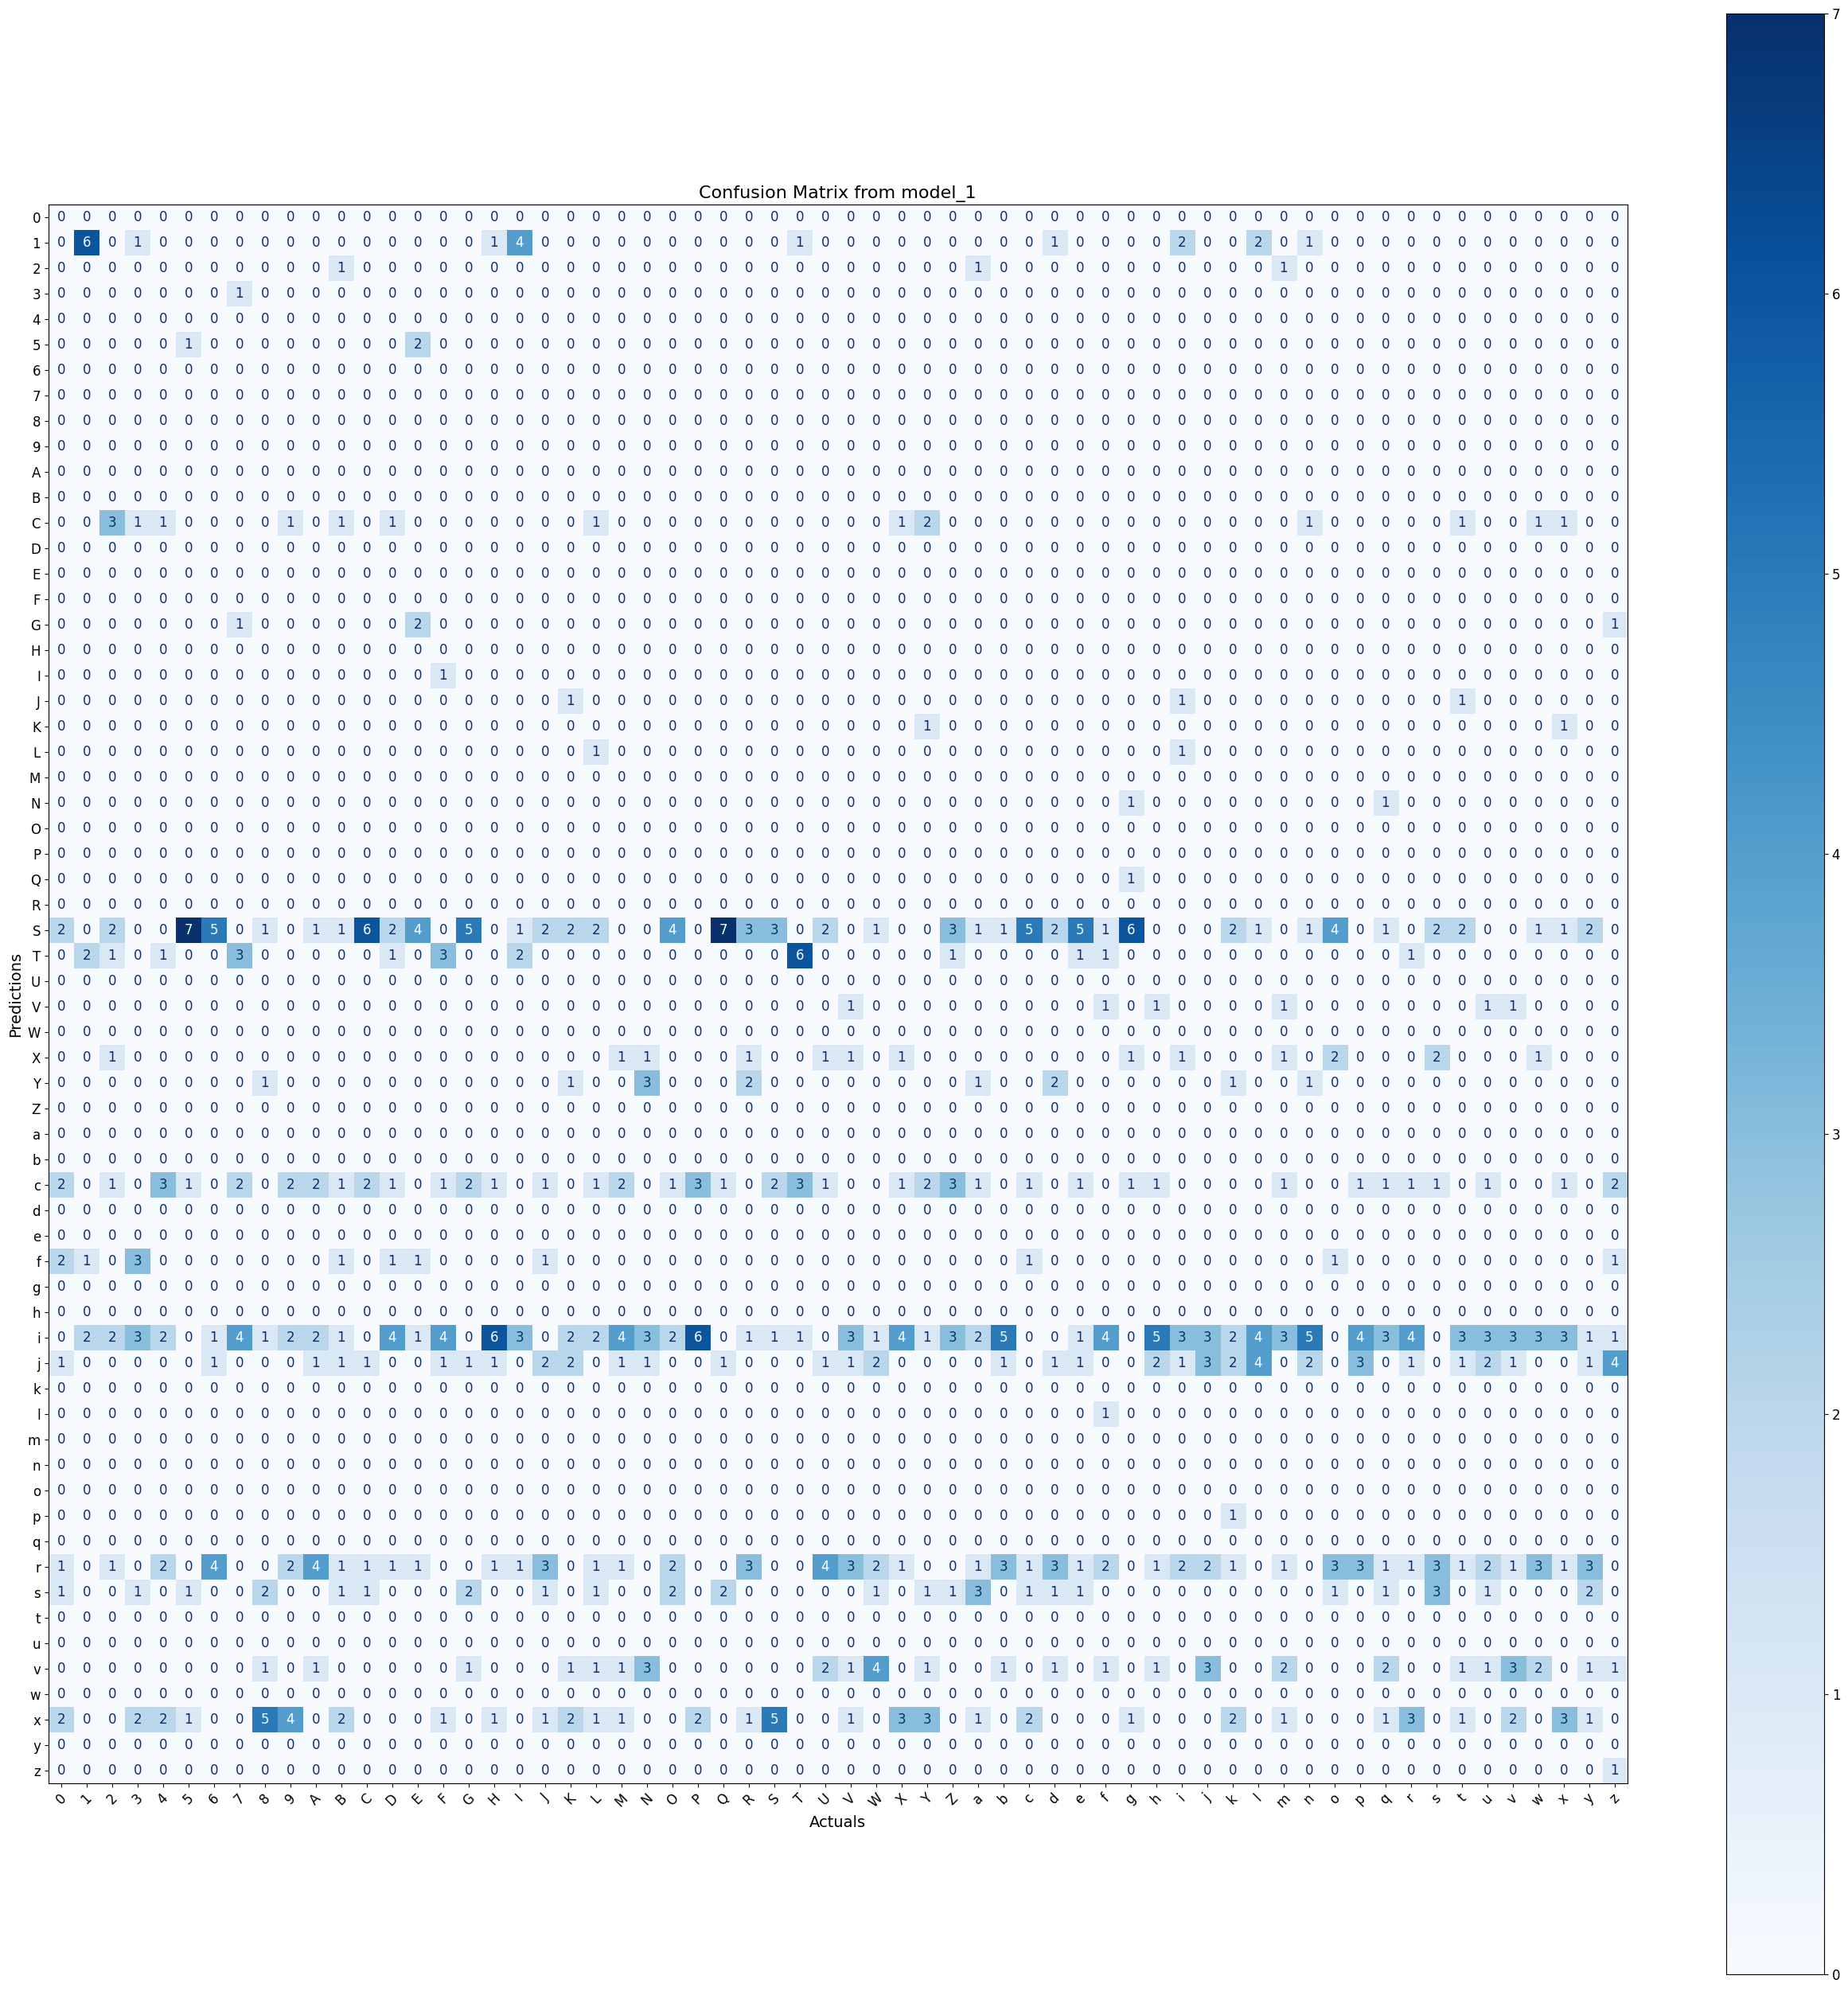

In [235]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(32, 32))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [226]:
np.set_printoptions(precision=2)
# classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names)
print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.15      0.55      0.24        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        11
           A       0.00      0.00      0.00        11
           B       0.00      0.00      0.00        11
           C       0.00      0.00      0.00        11
           D       0.00      0.00      0.00        11
           E       0.50      0.09      0.15        11
           F       0.00      0.00      0.00        11
           G       1.00      0.09      0.17        11
           H       0.00    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.